Filled 0 samples into Replay Buffer
Filled 1000 samples into Replay Buffer
Filled 2000 samples into Replay Buffer
Filled 3000 samples into Replay Buffer
Filled 4000 samples into Replay Buffer
Epoch 1/10, DDPG-Net Loss: 0.0217, Critic Loss: 0.3596, Actor Loss: -0.1193
Epoch 2/10, DDPG-Net Loss: 0.0212, Critic Loss: 0.4262, Actor Loss: 0.0403
Epoch 3/10, DDPG-Net Loss: 0.0258, Critic Loss: 0.3089, Actor Loss: 0.0648
Epoch 4/10, DDPG-Net Loss: 0.0366, Critic Loss: 0.4131, Actor Loss: 0.0109
Epoch 5/10, DDPG-Net Loss: 0.0424, Critic Loss: 0.3192, Actor Loss: 0.0345
Epoch 6/10, DDPG-Net Loss: 0.0382, Critic Loss: 0.3572, Actor Loss: 0.1047
Epoch 7/10, DDPG-Net Loss: 0.0387, Critic Loss: 0.2817, Actor Loss: 0.1047
Epoch 8/10, DDPG-Net Loss: 0.0252, Critic Loss: 0.3695, Actor Loss: 0.1194
Epoch 9/10, DDPG-Net Loss: 0.0172, Critic Loss: 0.3217, Actor Loss: 0.1727
Epoch 10/10, DDPG-Net Loss: 0.0146, Critic Loss: 0.2965, Actor Loss: 0.1789
DDPG-Net Predicted Actions:
 tensor([[ 0.2499, -0.0665],

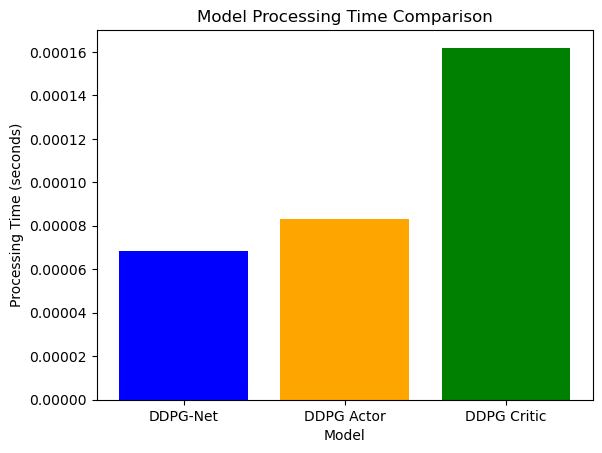

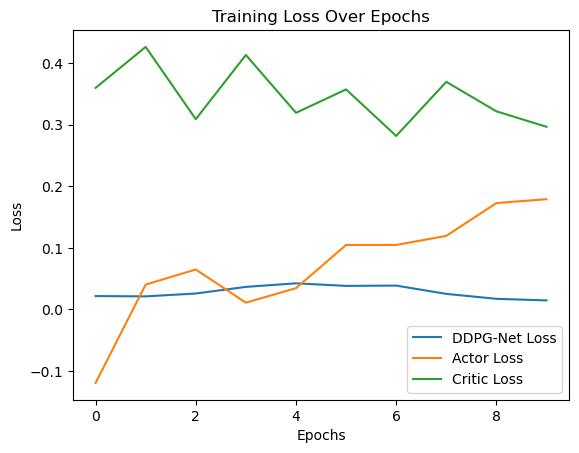

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Replay Buffer to store experiences
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_size):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_size))
        self.reward = np.zeros((max_size, 1))
        self.next_state = np.zeros((max_size, state_dim))
        self.done = np.zeros((max_size, 1))

    def add(self, state, action, reward, next_state, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.reward[self.ptr] = reward
        self.next_state[self.ptr] = next_state
        self.done[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        indices = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.state[indices]),
            torch.FloatTensor(self.action[indices]),
            torch.FloatTensor(self.reward[indices]),
            torch.FloatTensor(self.next_state[indices]),
            torch.FloatTensor(self.done[indices])
        )

# DDPG-Net (Actor Network for Imitation Learning)
class DDPGNet(nn.Module):
    def __init__(self, state_dim, action_size, max_action):
        super(DDPGNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        # self.fc2 = nn.Linear(64, 128)
        self.action_output = nn.Linear(128, action_size)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        # x = torch.relu(self.fc2(x))
        action = torch.tanh(self.action_output(x)) * self.max_action
        return action

# Actor Model
class Actor(nn.Module):
    def __init__(self, state_dim, action_size, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.action_output = nn.Linear(128, action_size)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = torch.tanh(self.action_output(x)) * self.max_action
        return action

# Critic Model
class Critic(nn.Module):
    def __init__(self, state_dim, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_size, 400)
        self.fc2 = nn.Linear(400, 300)
        self.q_output = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_value = self.q_output(x)
        return q_value
    
# Plot time comparison function
def plot_time_comparison(ddpg_net_time, ddpg_actor_time, ddpg_critic_time):
    times = [ddpg_net_time, ddpg_actor_time, ddpg_critic_time]
    labels = ['DDPG-Net', 'DDPG Actor', 'DDPG Critic']
    
    plt.bar(labels, times, color=['blue', 'orange', 'green'])
    plt.xlabel("Model")
    plt.ylabel("Processing Time (seconds)")
    plt.title("Model Processing Time Comparison")
    plt.show()

def simulate_model_performance(ddpg_net, actor_model, critic_model, num_samples, state_dim, action_size):
    # Generate random state inputs
    state_inputs = torch.rand(num_samples, state_dim)

    # DDPG-NET processing time
    start_time = time.time()
    ddpg_net_predicted_actions = ddpg_net(state_inputs)
    ddpg_net_time = time.time() - start_time

    # Actor processing time
    start_time = time.time()
    actor_predicted_actions = actor_model(state_inputs)
    ddpg_actor_time = time.time() - start_time

    # Critic processing time
    start_time = time.time()
    q_values = critic_model(state_inputs, actor_predicted_actions)
    ddpg_critic_time = time.time() - start_time

    print("DDPG-Net Predicted Actions:\n", ddpg_net_predicted_actions)
    print("\nDDPG Actor Predicted Actions:\n", actor_predicted_actions)
    print("\nDDPG Critic Q-Values:\n", q_values)

    print(f"\nDDPG-Net processing time: {ddpg_net_time:.6f} seconds")
    print(f"DDPG Actor processing time: {ddpg_actor_time:.6f} seconds")
    print(f"DDPG Critic processing time: {ddpg_critic_time:.6f} seconds")

    return ddpg_net_time, ddpg_actor_time, ddpg_critic_time

# Training Function with Replay Buffer
def train_ddpg_with_replay(ddpg_net, actor_model, critic_model, target_actor, target_critic, replay_buffer, optimizer_actor, optimizer_critic, optimizer_ddpg_net, batch_size, gamma=0.99, tau=0.005):
    # Sample a batch of experiences
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Train DDPG-Net (Mimic Actor)
    optimizer_ddpg_net.zero_grad()
    expert_actions = actor_model(states).detach()
    ddpg_net_predicted_actions = ddpg_net(states)
    ddpg_net_loss = nn.MSELoss()(ddpg_net_predicted_actions, expert_actions)
    ddpg_net_loss.backward()
    optimizer_ddpg_net.step()

    # Train Critic
    optimizer_critic.zero_grad()
    next_actions = target_actor(next_states).detach()
    target_q_values = rewards + (1 - dones) * gamma * target_critic(next_states, next_actions).detach()
    q_values = critic_model(states, actions)
    critic_loss = nn.MSELoss()(q_values, target_q_values)
    critic_loss.backward()
    optimizer_critic.step()

    # Train Actor
    optimizer_actor.zero_grad()
    predicted_actions = actor_model(states)
    actor_loss = -critic_model(states, predicted_actions).mean()
    actor_loss.backward()
    optimizer_actor.step()

    # Soft update for target networks
    for param, target_param in zip(critic_model.parameters(), target_critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    for param, target_param in zip(actor_model.parameters(), target_actor.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    return ddpg_net_loss.item(), critic_loss.item(), actor_loss.item()

# Plot Losses
def plot_losses(ddpg_net_losses, actor_losses, critic_losses):
    plt.plot(ddpg_net_losses, label="DDPG-Net Loss")
    plt.plot(actor_losses, label="Actor Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

# Main Program
if __name__ == "__main__":
    state_dim = 6
    action_size = 2
    max_action = 1.0
    epochs = 10  # For quick testing
    batch_size = 32
    replay_buffer_size = 100000
    num_samples = 100  # Used for performance simulation

    # Initialize models
    ddpg_net = DDPGNet(state_dim, action_size, max_action)
    actor_model = Actor(state_dim, action_size, max_action)
    critic_model = Critic(state_dim, action_size)
    target_actor = Actor(state_dim, action_size, max_action)
    target_critic = Critic(state_dim, action_size)

    # Copy weights from models to target models
    target_actor.load_state_dict(actor_model.state_dict())
    target_critic.load_state_dict(critic_model.state_dict())

    # Optimizers
    optimizer_ddpg_net = optim.Adam(ddpg_net.parameters(), lr=1e-3)
    optimizer_actor = optim.Adam(actor_model.parameters(), lr=1e-3)
    optimizer_critic = optim.Adam(critic_model.parameters(), lr=1e-3)

    # Replay Buffer
    replay_buffer = ReplayBuffer(max_size=replay_buffer_size, state_dim=state_dim, action_size=action_size)

    # Populate the replay buffer with initial random experiences
    for i in range(5000):  # Pre-fill buffer with random samples
        state = np.random.rand(state_dim)
        action = np.random.uniform(-max_action, max_action, action_size)
        reward = np.random.uniform(-1, 1)
        next_state = np.random.rand(state_dim)
        done = np.random.choice([0, 1])
        replay_buffer.add(state, action, reward, next_state, done)
        if i % 1000 == 0:
            print(f"Filled {i} samples into Replay Buffer")

    # Training loop
    ddpg_net_losses, actor_losses, critic_losses = [], [], []
    for epoch in range(epochs):
        if replay_buffer.size > batch_size:
            ddpg_net_loss, critic_loss, actor_loss = train_ddpg_with_replay(
                ddpg_net, actor_model, critic_model, target_actor, target_critic, replay_buffer,
                optimizer_actor, optimizer_critic, optimizer_ddpg_net, batch_size
            )
            ddpg_net_losses.append(ddpg_net_loss)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            print(f"Epoch {epoch+1}/{epochs}, DDPG-Net Loss: {ddpg_net_loss:.4f}, Critic Loss: {critic_loss:.4f}, Actor Loss: {actor_loss:.4f}")
    
    # Performance comparison
    ddpg_net_time, ddpg_actor_time, ddpg_critic_time = simulate_model_performance(
        ddpg_net, actor_model, critic_model, num_samples, state_dim, action_size
    )

    # Plot time comparison
    plot_time_comparison(ddpg_net_time, ddpg_actor_time, ddpg_critic_time)

    # Plot training losses
    plot_losses(ddpg_net_losses, actor_losses, critic_losses)
